In [43]:
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

In [44]:
# read datasets 
enc = pd.read_csv('../../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../../data/regional_datasets/univariate/esc_data_univ.csv')
mid_atlantic = pd.read_csv('../../data/regional_datasets/univariate/mid_atlantic_data_univ.csv')
mountain = pd.read_csv('../../data/regional_datasets/univariate/mountain_data_univ.csv')
new_england = pd.read_csv('../../data/regional_datasets/univariate/new_england_data_univ.csv')
pacific = pd.read_csv('../../data/regional_datasets/univariate/pacific_data_univ.csv')
south_atlantic = pd.read_csv('../../data/regional_datasets/univariate/south_atlantic_data_univ.csv')
wnc = pd.read_csv('../../data/regional_datasets/univariate/wnc_data_univ.csv')
wsc = pd.read_csv('../../data/regional_datasets/univariate/wsc_data_univ.csv')
# ignore values before march 
enc = enc[enc.date >= "2020-03-01"]
esc = esc[esc.date >= "2020-03-01"]
mid_atlantic = mid_atlantic[mid_atlantic.date >= "2020-03-01"]
mountain = mountain[mountain.date >= "2020-03-01"]
new_england = new_england[new_england.date >= "2020-03-01"]
pacific = pacific[pacific.date >= "2020-03-01"]
south_atlantic = south_atlantic[south_atlantic.date >= "2020-03-01"]
wnc = wnc[wnc.date >= "2020-03-01"]
wsc = wsc[wsc.date >= "2020-03-01"]

datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df.set_index(pd.to_datetime(df['date']), inplace=True)
    df.drop(columns=["Unnamed: 0", "date"], axis=1, inplace=True)
    df.sort_index(inplace=True)
    


# ARIMA

In [48]:
def build_arima_model(df, params=None, plot=False, test_perf = False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])

    if not params:
        params = (7,1,7)

    # validation step
    
    model = ARIMA(train, order=params)
    model_fit = model.fit()

    val_pred = model_fit.forecast(steps=len(val))
    
    mae = round(mean_absolute_error(val, val_pred), 2)
    rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
    mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
    aic = round(model_fit.aic, 2)

    print(f"Validatation Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
   
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Validation ARIMA Predictions for {region}')
        plt.plot(val.index, val, label='True Val')
        plt.plot(val_pred.index, val_pred, label='Predicted')
        plt.legend() 
        plt.show()

    # test 
    if test_perf:
        model = ARIMA(train_val, order=params)
        model_fit = model.fit()

        test_pred = model_fit.forecast(steps=len(test))
        test_pred[test_pred < 0] = 0
        mae = round(mean_absolute_error(test, test_pred), 2)
        rmse = round(mean_squared_error(test, test_pred, squared=False), 2)
        mase = round(mean_absolute_scaled_error(test, test_pred, y_train=train_val), 2)
        aic = round(model_fit.aic, 2)

        print(f"Test Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
        
        # plot both validation and test
        # if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Test ARIMA Predictions for {region}')
        # plt.plot(val.index, val, label='True Val', color="#1f77b4")
        # plt.plot(val_pred.index, val_pred, label='Val Predicted', color="purple")
        plt.plot(test.index, test, label='True Test')
        plt.plot(test_pred.index, test_pred, label='Test Predicted')
        plt.legend() 
        plt.show()

    print(f"Training for {region} complete")

Training model for East North Central...
Validatation Stats= AIC: 15784.55, MASE: 0.88, RMSE: 11889.74, MAE: 7560.57


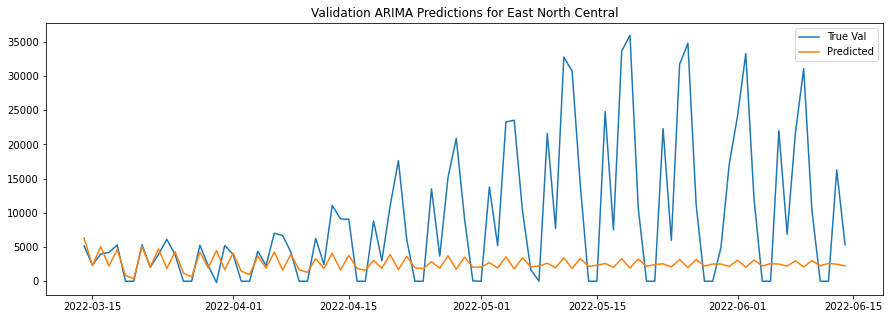

Test Stats= AIC: 17682.06, MASE: 0.98, RMSE: 10421.94, MAE: 8386.1


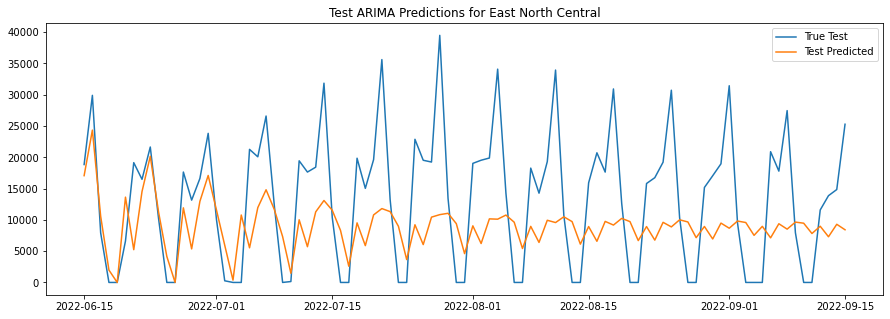

Training for East North Central complete

Training model for East South Central...
Validatation Stats= AIC: 14924.78, MASE: 0.53, RMSE: 3008.81, MAE: 1884.23


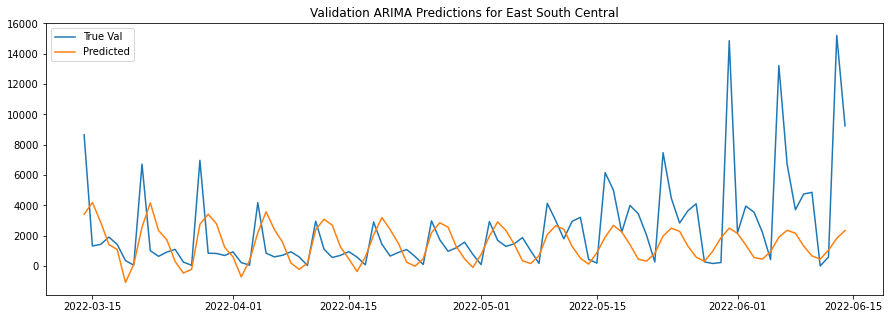

Test Stats= AIC: 16715.01, MASE: 1.32, RMSE: 6152.87, MAE: 4530.32


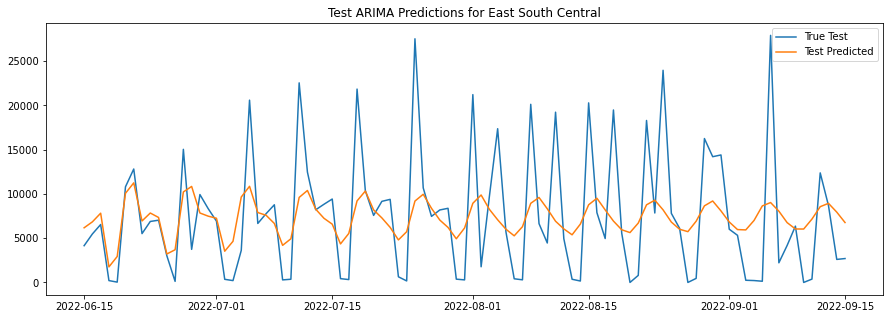

Training for East South Central complete

Training model for Mid-Atlantic...
Validatation Stats= AIC: 14622.17, MASE: 3.78, RMSE: 10968.94, MAE: 8454.82


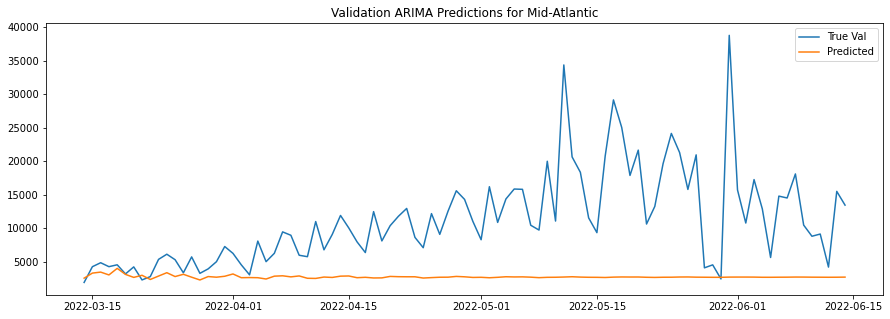

Test Stats= AIC: 16498.38, MASE: 2.03, RMSE: 6083.96, MAE: 5044.81


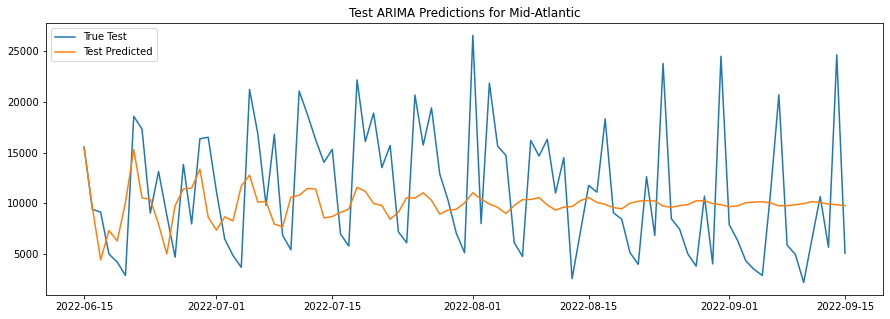

Training for Mid-Atlantic complete

Training model for Mountain...
Validatation Stats= AIC: 14967.61, MASE: 0.92, RMSE: 5366.69, MAE: 3062.48


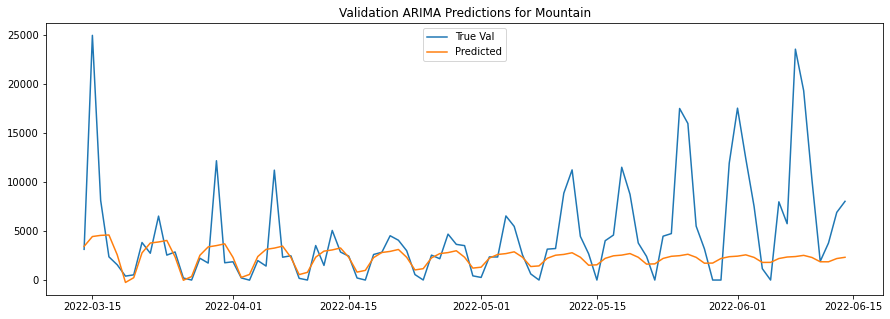

Test Stats= AIC: 16789.59, MASE: 2.04, RMSE: 7913.94, MAE: 6822.64


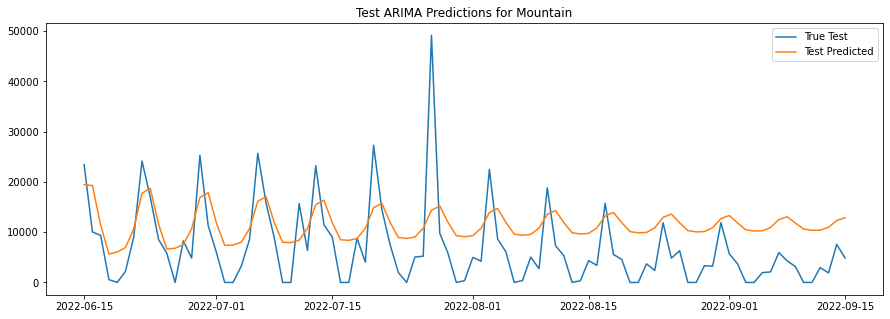

Training for Mountain complete

Training model for New England...
Validatation Stats= AIC: 14694.62, MASE: 1.37, RMSE: 5375.01, MAE: 3646.03


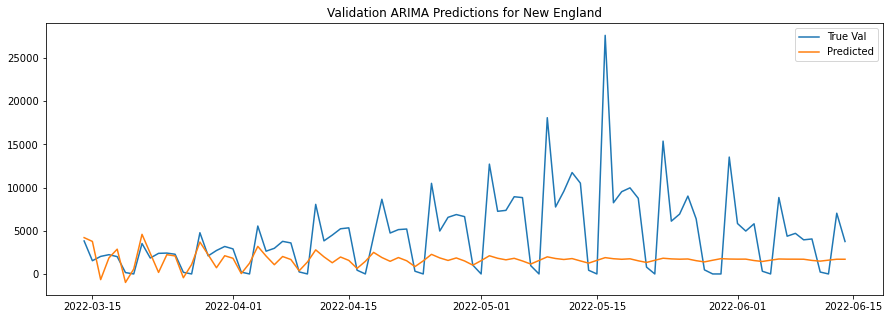

Test Stats= AIC: 16476.75, MASE: 0.88, RMSE: 3252.42, MAE: 2413.81


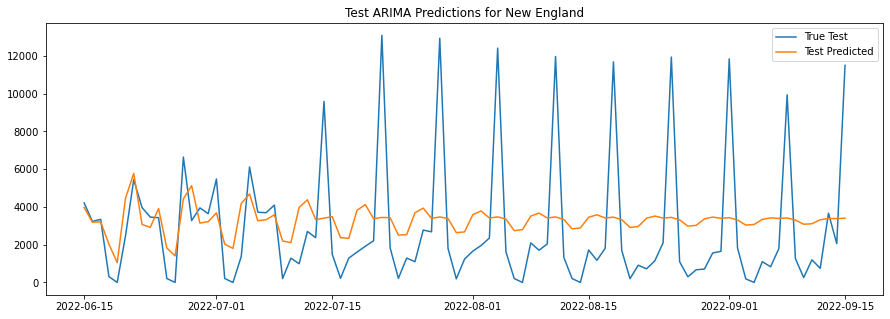

Training for New England complete

Training model for Pacific...
Validatation Stats= AIC: 15991.21, MASE: 1.41, RMSE: 16930.64, MAE: 9977.87


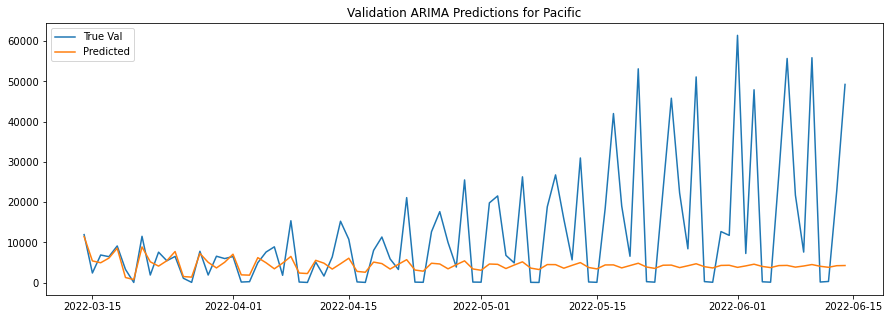

Test Stats= AIC: 17977.86, MASE: 1.62, RMSE: 15416.17, MAE: 12790.67


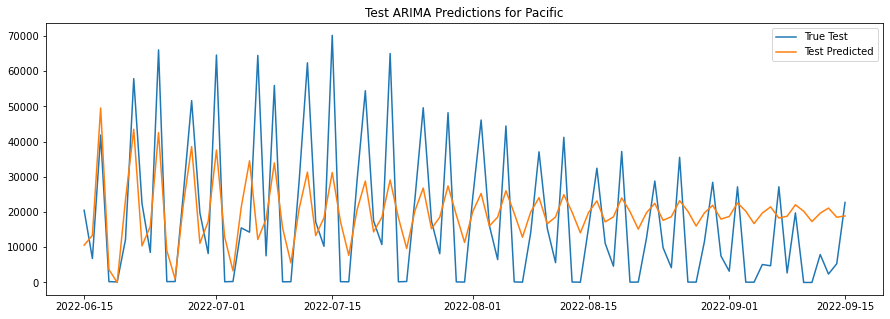

Training for Pacific complete

Training model for South Atlantic...
Validatation Stats= AIC: 16666.19, MASE: 0.88, RMSE: 16457.81, MAE: 10007.61


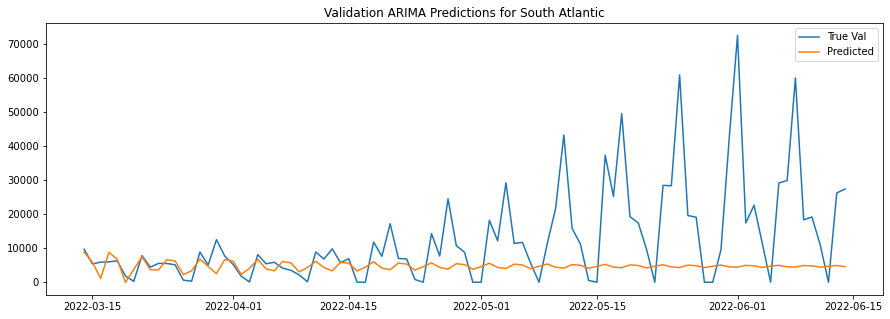

Test Stats= AIC: 18680.33, MASE: 1.42, RMSE: 21517.11, MAE: 15855.96


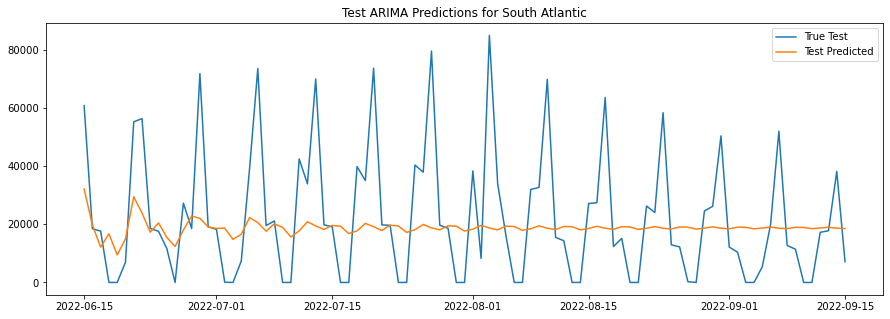

Training for South Atlantic complete

Training model for West North Central...
Validatation Stats= AIC: 14816.55, MASE: 0.66, RMSE: 2887.75, MAE: 2252.3


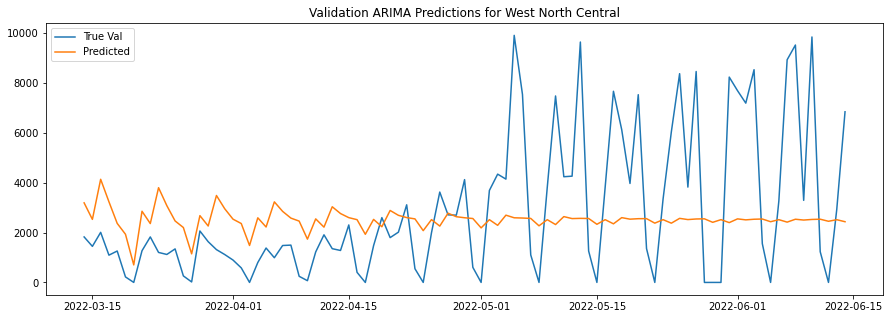

Test Stats= AIC: 16582.1, MASE: 1.12, RMSE: 4327.43, MAE: 3673.44


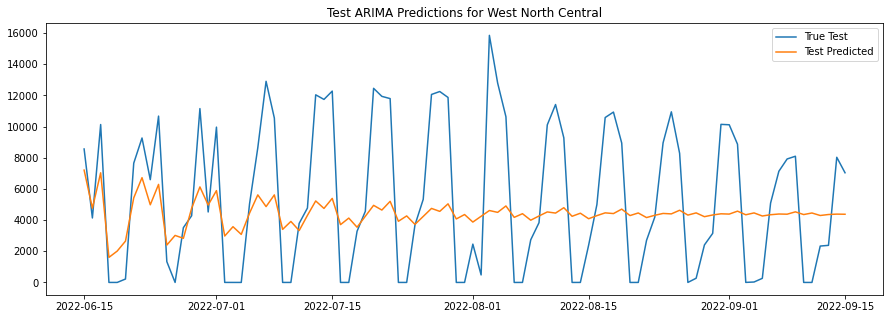

Training for West North Central complete

Training model for West South Central...
Validatation Stats= AIC: 15609.47, MASE: 0.73, RMSE: 4150.35, MAE: 3504.22


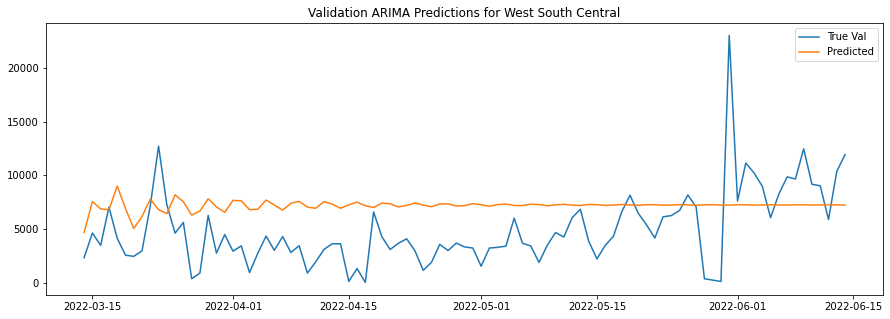

Test Stats= AIC: 17476.62, MASE: 1.86, RMSE: 10280.28, MAE: 8324.92


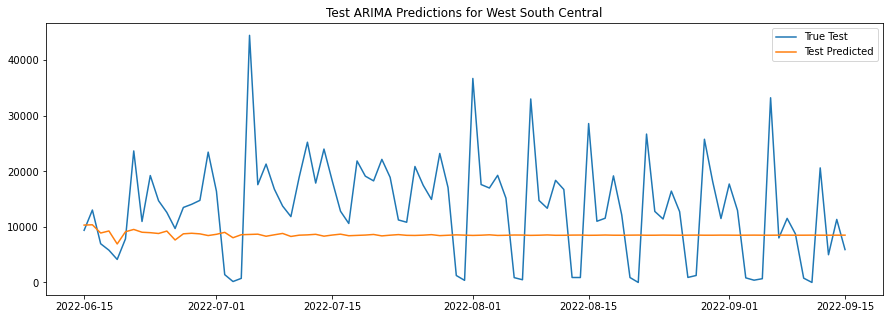

Training for West South Central complete

--- 473.01 seconds ---


In [49]:
start_time = time.time()
for df in datasets:
    build_arima_model(df, plot=True, test_perf=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

## Parameter Optimization

In [50]:
def parameter_tune(df):
    region = df["region"].iloc[0]
    print(f"Optimizing model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])
    # validation step
    


    results = []
    for p in range(5, 9):
        for d in range(2):
            for q in range(5, 9):
                model = ARIMA(train, order=(p,d,q))
                model_fit = model.fit()

                # pred = model_fit.forecast(steps=size)

                val_pred = model_fit.forecast(steps=len(val))
    
                mae = round(mean_absolute_error(val, val_pred), 2)
                rmse = round(mean_squared_error(val, val_pred, squared=False), 2)
                mase = round(mean_absolute_scaled_error(val, val_pred, y_train=train), 2)
                aic = round(model_fit.aic, 2)

                results.append([p, d, q, model_fit.aic, mae, rmse, mase])
                
    results = pd.DataFrame(results, columns=["p", "d", "q", "aic", "mae", "rmse", "mase"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())

In [51]:
start_time = time.time()
for df in datasets:
    parameter_tune(df)
    print("")

print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Optimizing model for East North Central...
    p  d  q           aic      mae      rmse  mase
16  7  0  5  15835.371620  6796.37   9349.05  0.79
11  6  0  8  16110.310306  6740.75   9059.75  0.79
18  7  0  7  15819.907213  6864.16   9263.39  0.80
17  7  0  6  15817.543298  6862.91   9244.82  0.80
23  7  1  8  15768.542401  6935.30  11125.80  0.81

Optimizing model for East South Central...
    p  d  q           aic      mae     rmse  mase
5   5  1  6  14961.947692  1801.34  2949.10  0.50
6   5  1  7  14943.380082  1799.74  2930.76  0.50
15  6  1  8  14932.489395  1837.85  2958.33  0.51
23  7  1  8  14927.721543  1823.57  2993.36  0.51
7   5  1  8  14945.785338  1810.34  2918.04  0.51

Optimizing model for Mid-Atlantic...
    p  d  q           aic      mae     rmse  mase
26  8  0  7  14632.648151  3981.77  5739.04  1.78
10  6  0  7  14636.051700  4012.49  5768.07  1.79
19  7  0  8  14632.717287  4029.30  5764.69  1.80
18  7  0  7  14630.927800  4032.27  5765.38  1.80
27  8  0  8  14634.

## Final ARIMA

In [52]:

params = {
    "East North Central": (7, 0, 5),
    "East South Central": (5, 1, 6),
    "Mid-Atlantic": (8, 0, 7),
    "Mountain": (6, 1, 6),  
    "New England": (8, 0, 5),
    "Pacific": (5, 0, 6),
    "South Atlantic": (6, 0, 7),
    "West North Central": (8, 1, 5),
    "West South Central": (6, 1, 5),
}

In [53]:
def final_arima_model(df, params=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    train_df, temp_test_df = train_test_split(df, test_size=0.2, shuffle=False)
    val_df, test_df  = train_test_split(temp_test_df, test_size=0.5, shuffle=False)

    train = train_df['new_confirmed']
    test = test_df['new_confirmed']
    val = val_df['new_confirmed']
    train_val = pd.concat([train, val])

    if not params:
        params = (4,1,4)

    # validation step
    
    model = ARIMA(train_val, order=params)
    model_fit = model.fit()

    test_pred = model_fit.forecast(steps=len(test))
    test_pred[test_pred < 0] = 0

    mae = round(mean_absolute_error(test, test_pred), 2)
    rmse = round(mean_squared_error(test, test_pred, squared=False), 2)
    mase = round(mean_absolute_scaled_error(test, test_pred, y_train=train_val), 2)
    aic = round(model_fit.aic, 2)
    

    print(f"Test Stats= AIC: {aic}, MASE: {mase}, RMSE: {rmse}, MAE: {mae}")
   
    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'Test ARIMA Predictions for {region}')
        plt.plot(test.index, test, label='True Test')
        plt.plot(test_pred.index, test_pred, label='Predicted')
    
        plt.legend() 
        plt.show()



Training model for East North Central...
Test Stats= AIC: 17737.02, MASE: 0.95, RMSE: 9437.74, MAE: 8152.96


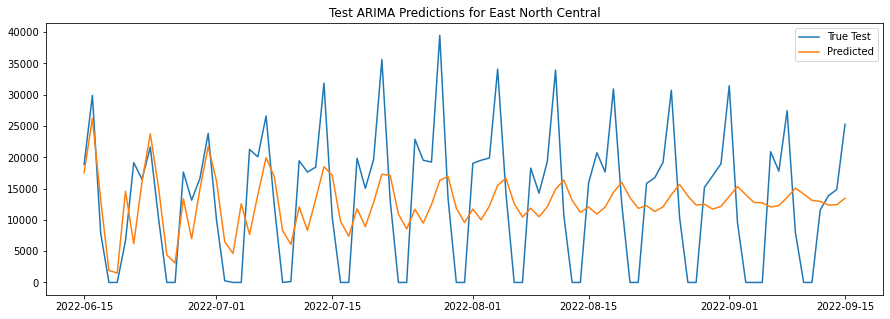


Training model for East South Central...
Test Stats= AIC: 16751.76, MASE: 1.33, RMSE: 6330.24, MAE: 4566.18


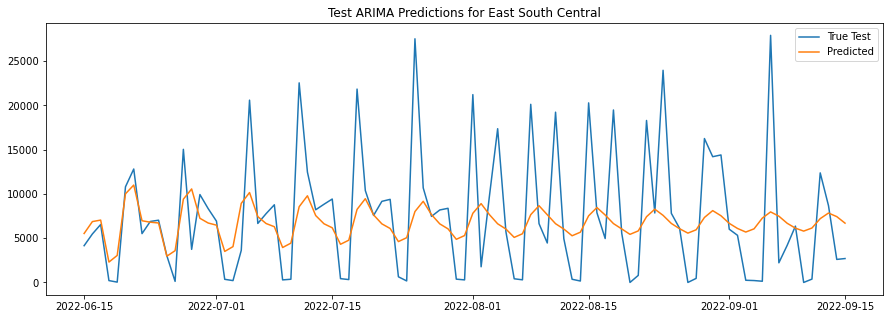


Training model for Mid-Atlantic...
Test Stats= AIC: 16505.52, MASE: 2.14, RMSE: 6095.2, MAE: 5310.99


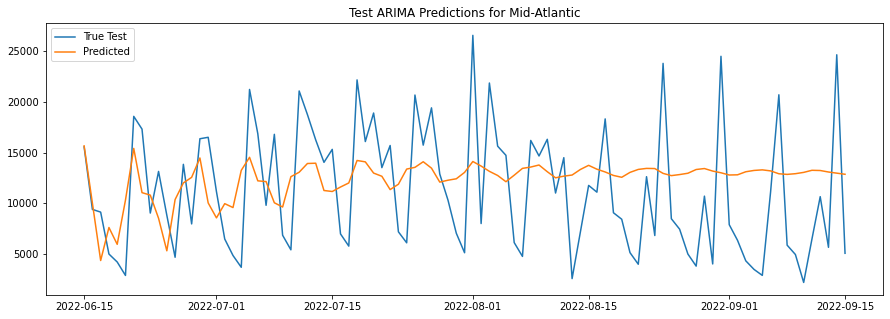


Training model for Mountain...
Test Stats= AIC: 16783.79, MASE: 2.03, RMSE: 7858.13, MAE: 6802.06


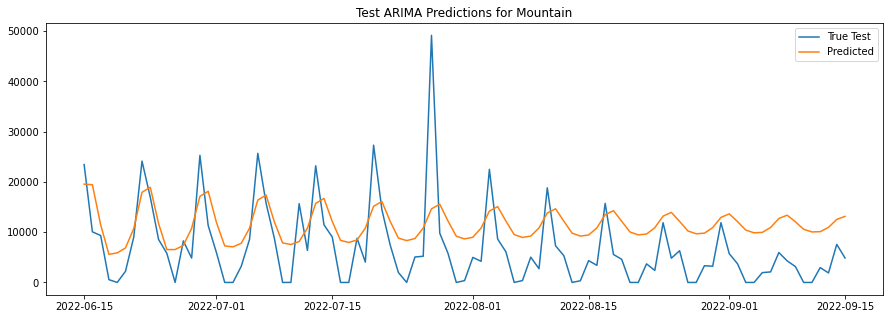


Training model for New England...
Test Stats= AIC: 16506.07, MASE: 1.06, RMSE: 3449.48, MAE: 2924.06


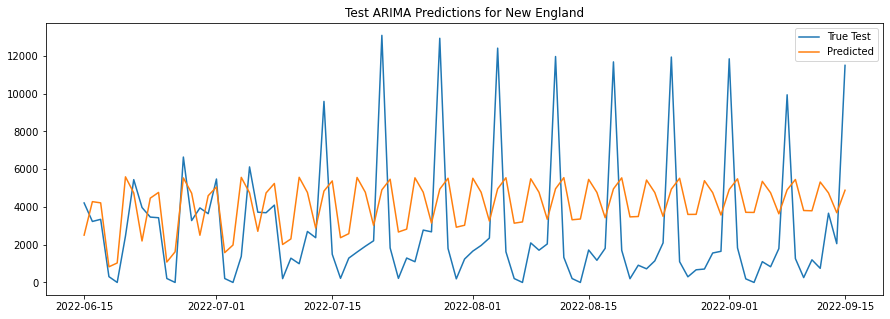


Training model for Pacific...
Test Stats= AIC: 18225.03, MASE: 1.51, RMSE: 15111.75, MAE: 11949.52


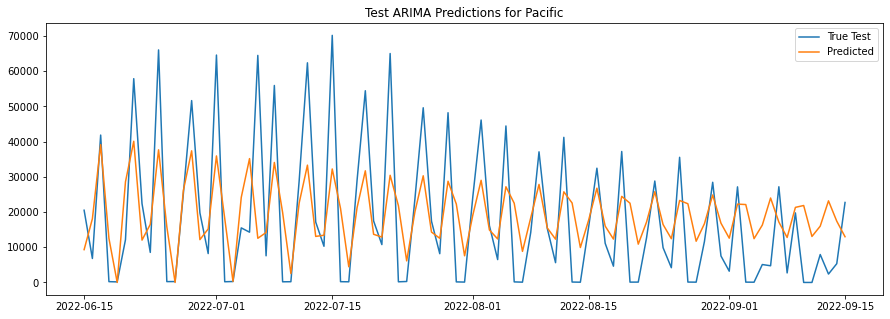


Training model for South Atlantic...
Test Stats= AIC: 18736.66, MASE: 1.29, RMSE: 19492.95, MAE: 14437.06


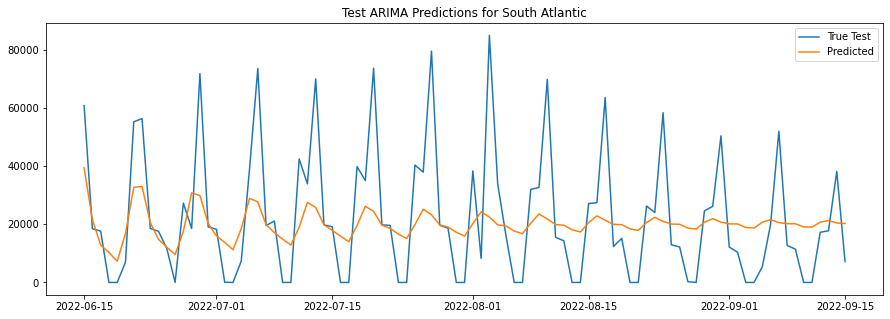


Training model for West North Central...
Test Stats= AIC: 16577.22, MASE: 1.07, RMSE: 4169.53, MAE: 3502.58


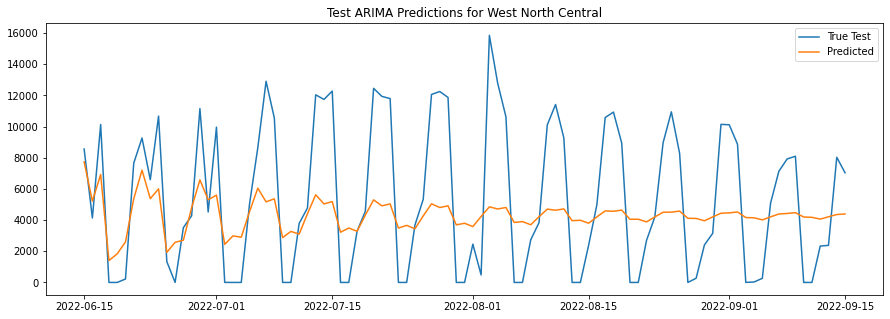


Training model for West South Central...
Test Stats= AIC: 17526.76, MASE: 1.7, RMSE: 9589.93, MAE: 7628.5


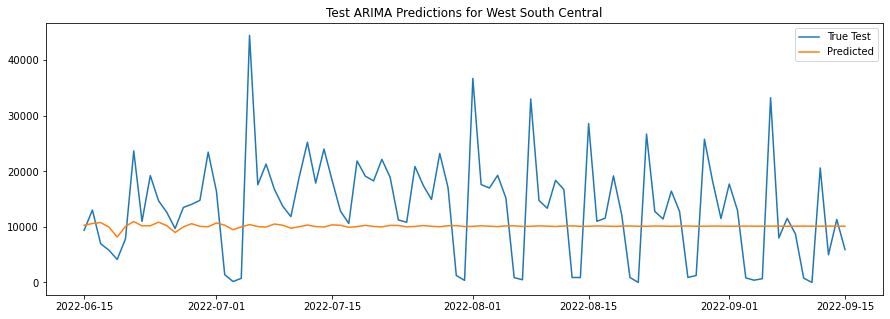


--- 226.2 seconds ---


In [54]:
start_time = time.time()
for df in datasets:
    final_arima_model(df, params=params[df["region"].iloc[0]], plot=True)
    print("")

print(f"--- {round(time.time() - start_time, 2)} seconds ---")